# **Lyft Analytics Assignment**

I am going to conduct some Exploratory Data Analysis as well as do some Feature Engineering to better understand the main factors that affect a driver’s lifetime value. I will then do some modelling to find the optimal features for predicting churn.

In [1]:
# Libraries for analysis and plotting
import numpy as np
import pandas as pd
import datetime as dt

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
plt.style.use('fivethirtyeight')

## Load the datasets

In [2]:
drivers = pd.read_csv('Resources/driver_ids.csv')
rides_id = pd.read_csv('Resources/ride_ids.csv')
rides_times = pd.read_csv('Resources/ride_timestamps.csv')

Let's look at the three dataframes in more detail.

### drivers

#### **Data Fields**
- **driver_id** - Unique identifier for a driver
- **driver_onboard_date** - Date on which driver was on-boarded

In [3]:
# Let's look at the first few rows
drivers.head(2)

,driver_id,driver_onboard_date
0,002be0ffdc997bd5c50703158b7c2491,2016-03-29 00:00:00
1,007f0389f9c7b03ef97098422f902e62,2016-03-29 00:00:00


In [4]:
drivers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 937 entries, 0 to 936
Data columns (total 2 columns):
driver_id              937 non-null object
driver_onboard_date    937 non-null object
dtypes: object(2)
memory usage: 14.7+ KB


We can see that there are 937 unique driver ids with corresponding start dates for the drivers.

There are no null values but the timestamp is a string, this will need to be converted to a datetime item.

In [5]:
drivers['driver_onboard_date'] = pd.to_datetime(drivers['driver_onboard_date'])

### rides_id

#### **Data Fields**
- **driver_id** - Unique identifier for a driver
- **ride_id** - Unique identifier for a ride that was completed by the driver
- **ride_distance** - Ride distance in meters
- **ride_duration** - Ride durations in seconds
- **ride_prime_time** - PrimeTime applied on the ride

In [6]:
# Let's look at the first few rows
rides_id.head(2)

,driver_id,ride_id,ride_distance,ride_duration,ride_prime_time
0,002be0ffdc997bd5c50703158b7c2491,006d61cf7446e682f7bc50b0f8a5bea5,1811,327,50
1,002be0ffdc997bd5c50703158b7c2491,01b522c5c3a756fbdb12e95e87507eda,3362,809,0


In [7]:
rides_id.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 193502 entries, 0 to 193501
Data columns (total 5 columns):
driver_id          193502 non-null object
ride_id            193502 non-null object
ride_distance      193502 non-null int64
ride_duration      193502 non-null int64
ride_prime_time    193502 non-null int64
dtypes: int64(3), object(2)
memory usage: 7.4+ MB


We can see that there is data on 193502 different lyft journeys and there are no null values.

### rides_times

#### **Data Fields**
- **ride_id** - Unique identifier for a ride
- **event** - event describes the type of event (see below)
- **timestamp** - Time of event

**Overview of the event types:**
- **requested_at** - passenger requested a ride
- **accepted_at** - driver accepted a passenger request
- **arrived_at** - driver arrived at pickup point
- **picked_up_at** - driver picked up the passenger
- **dropped_off_at** - driver dropped off a passenger at destination

In [8]:
# Let's look at the first few rows
rides_times.head(2)

,ride_id,event,timestamp
0,00003037a262d9ee40e61b5c0718f7f0,requested_at,2016-06-13 09:39:19
1,00003037a262d9ee40e61b5c0718f7f0,accepted_at,2016-06-13 09:39:51


In [9]:
rides_times.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 970405 entries, 0 to 970404
Data columns (total 3 columns):
ride_id      970405 non-null object
event        970405 non-null object
timestamp    970404 non-null object
dtypes: object(3)
memory usage: 22.2+ MB


We can see that there is data on 970405 different lyft journey events and there is a null value in the timestamp.

I will first convert the timestamp to a datetime item.

The dataframe is also in long format, I will change from long format to wide format to make it easier for Feature Engineering. 

In [10]:
rides_times['timestamp'] = pd.to_datetime(rides_times['timestamp'])

In [11]:
rides_times = rides_times.pivot(index='ride_id', columns='event', values='timestamp')

In [12]:
# Let's look at the amended rides_times dataframe
rides_times.head(2)

event,accepted_at,arrived_at,dropped_off_at,picked_up_at,requested_at
ride_id,,,,,
00003037a262d9ee40e61b5c0718f7f0,2016-06-13 09:39:51,2016-06-13 09:44:31,2016-06-13 10:03:05,2016-06-13 09:44:33,2016-06-13 09:39:19
00005eae40882760d675da5effb89ae3,2016-05-14 05:23:25,2016-05-14 05:26:17,2016-05-14 05:34:17,2016-05-14 05:26:18,2016-05-14 05:23:21


In [13]:
rides_times.info()

<class 'pandas.core.frame.DataFrame'>
Index: 194081 entries, 00003037a262d9ee40e61b5c0718f7f0 to ffffccd77f47a3de26dfed9a851464b4
Data columns (total 5 columns):
accepted_at       194081 non-null datetime64[ns]
arrived_at        194080 non-null datetime64[ns]
dropped_off_at    194081 non-null datetime64[ns]
picked_up_at      194081 non-null datetime64[ns]
requested_at      194081 non-null datetime64[ns]
dtypes: datetime64[ns](5)
memory usage: 8.9+ MB


We can see that the dataframe has been widened with the values in the event column now forming their own columns. The number of rows have been reduced from 970405 to 194081.

There is one null value in the arrived_at column, I will leave this some the time being as it will not interfere with analysis as the trip duration is already included in the rides_id dataframe.

## Feature Engineering

There are a number of interesting features we can extract from the timestamp info in the drivers and rides_times dataframes.

From **drivers** - 

- extract the day, month and week of the year as well as month from the data frame

From **rides_times** - 

- extract the hour, day of the week, month, day of the year and week of the year
- determine the time taken for a driver to accept a request from a user

In [14]:
# Extract the features from drivers
drivers['driver_onboard_week'] = drivers['driver_onboard_date'].dt.weekofyear
drivers['driver_onboard_month'] = drivers['driver_onboard_date'].dt.month
drivers['driver_onboard_day'] = drivers['driver_onboard_date'].dt.dayofyear

In [15]:
# Extract the features from rides_timestamps
rides_times['accepted_time'] = (rides_times['accepted_at'] - rides_times['requested_at']).astype('timedelta64[s]')
rides_times['day_of_week'] = rides_times['accepted_at'].dt.weekday
rides_times['month'] = rides_times['accepted_at'].dt.month
rides_times['hour_of_day'] = rides_times['accepted_at'].dt.hour
rides_times['week_of_year'] = rides_times['accepted_at'].dt.weekofyear
rides_times['day_of_year'] = rides_times['accepted_at'].dt.dayofyear

In [16]:
# Create a new columen from the index and drop unwanted columns
rides_times['ride_id'] = rides_times.index
rides_times.drop(['accepted_at', 'arrived_at', 'dropped_off_at', 'picked_up_at', 'requested_at'], inplace=True, axis=1)

### Merge the dataframes

In [17]:
# Merge rides_times with rides_id
rides = pd.merge(rides_id, rides_times, on='ride_id', how='inner')
# Next merge new dataframe with drivers
rides = pd.merge(rides, drivers, on='driver_id', how='inner')

In [18]:
# Let's look at the new dataset
rides.head(2)

,driver_id,ride_id,ride_distance,ride_duration,ride_prime_time,accepted_time,day_of_week,month,hour_of_day,week_of_year,day_of_year,driver_onboard_date,driver_onboard_week,driver_onboard_month,driver_onboard_day
0,002be0ffdc997bd5c50703158b7c2491,006d61cf7446e682f7bc50b0f8a5bea5,1811,327,50,25.0,5,4,2,16,114,2016-03-29,13,3,89
1,002be0ffdc997bd5c50703158b7c2491,01b522c5c3a756fbdb12e95e87507eda,3362,809,0,3.0,1,3,19,13,89,2016-03-29,13,3,89


In [19]:
rides.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 184209 entries, 0 to 184208
Data columns (total 15 columns):
driver_id               184209 non-null object
ride_id                 184209 non-null object
ride_distance           184209 non-null int64
ride_duration           184209 non-null int64
ride_prime_time         184209 non-null int64
accepted_time           184209 non-null float64
day_of_week             184209 non-null int64
month                   184209 non-null int64
hour_of_day             184209 non-null int64
week_of_year            184209 non-null int64
day_of_year             184209 non-null int64
driver_onboard_date     184209 non-null datetime64[ns]
driver_onboard_week     184209 non-null int64
driver_onboard_month    184209 non-null int64
driver_onboard_day      184209 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(11), object(2)
memory usage: 22.5+ MB


#### **Overview of data Fields**
- **driver_id** - Unique identifier for a driver
- **ride_id** - Unique identifier for a ride that was completed by the driver
- **ride_distance** - Ride distance in meters
- **ride_duration** - Ride durations in seconds
- **ride_prime_time** - PrimeTime applied on the ride
- **accepted_time** - Time taken between user requesting ride and driver accepting
- **day_of_week** - Day the ride took place
- **month** - Month the ride took place
- **hour_of_day** - Hour of the day the ride took place
- **week_of_year** - Week of the year ride took place
- **day_of_year** - Day of the year ride took place
- **driver_onboard_date** - Date on which driver was on-boarded
- **driver_onboard_week** - Week of the year on which driver was on-boarded
- **driver_onboard_day** - Day of the year on which driver was on-boarded
- **driver_onboard_month** - Month on which driver was on-boarded

## Explotatory data analysis

I will next look at each of the different columns in the merged dataframe that have numerical values, the purpose of this is check for outliers and get a better understanding of the data.

In [20]:
rides.describe()

,ride_distance,ride_duration,ride_prime_time,accepted_time,day_of_week,month,hour_of_day,week_of_year,day_of_year,driver_onboard_week,driver_onboard_month,driver_onboard_day
count,184209.000000,184209.000000,184209.000000,184209.000000,184209.000000,184209.000000,184209.000000,184209.000000,184209.000000,184209.000000,184209.000000,184209.000000
mean,6945.197042,859.872292,17.373880,11.660608,3.145454,5.150378,14.173759,20.236737,141.802610,15.636228,4.102574,108.995326
std,8938.015943,572.846146,30.833558,36.515336,1.894497,0.754533,6.323163,3.179712,22.271292,1.931197,0.593697,13.777011
min,-2.000000,2.000000,0.000000,0.000000,0.000000,3.000000,0.000000,13.000000,88.000000,13.000000,3.000000,88.000000
25%,2457.000000,492.000000,0.000000,5.000000,2.000000,5.000000,10.000000,18.000000,126.000000,14.000000,4.000000,97.000000
50%,4007.000000,727.000000,0.000000,6.000000,3.000000,5.000000,15.000000,20.000000,142.000000,15.000000,4.000000,108.000000
75%,7169.000000,1070.000000,25.000000,9.000000,5.000000,6.000000,19.000000,23.000000,161.000000,17.000000,4.000000,120.000000
max,724679.000000,28204.000000,500.000000,5028.000000,6.000000,6.000000,23.000000,25.000000,178.000000,19.000000,5.000000,136.000000


Straight away I can see that there are some issues with the **ride_distance**, **ride_duration** and **accepted_time**.

### ride_distance

The ride distance ranges from -2 to 724679. It seems implausable to have a negative distance and the upper limit of the 7+ hours.

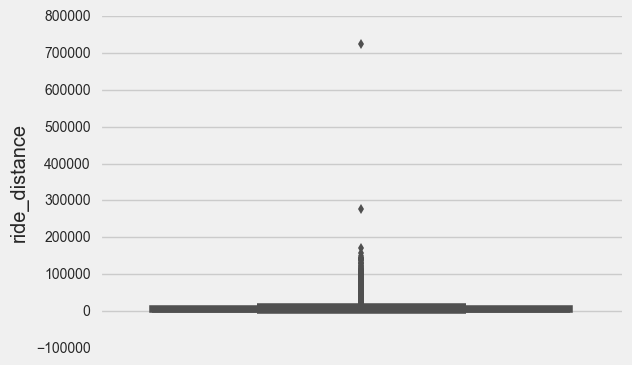

In [21]:
sns.boxplot(y=rides['ride_distance'])
sns.set_context('poster')
sns.set(style='white')
sns.despine(bottom=False)
plt.show()

From the boxplot above we can see that the majority of the journeys are less than 40,000 meters in distance. There are a couple of outliers above this value as well as several shorter distances. I will remove rows where where **ride_distance** is less than 500 meters and greater than 40,000 metres.

In [22]:
rides = rides[(rides.ride_distance > 500) & (rides.ride_distance < 40000)]

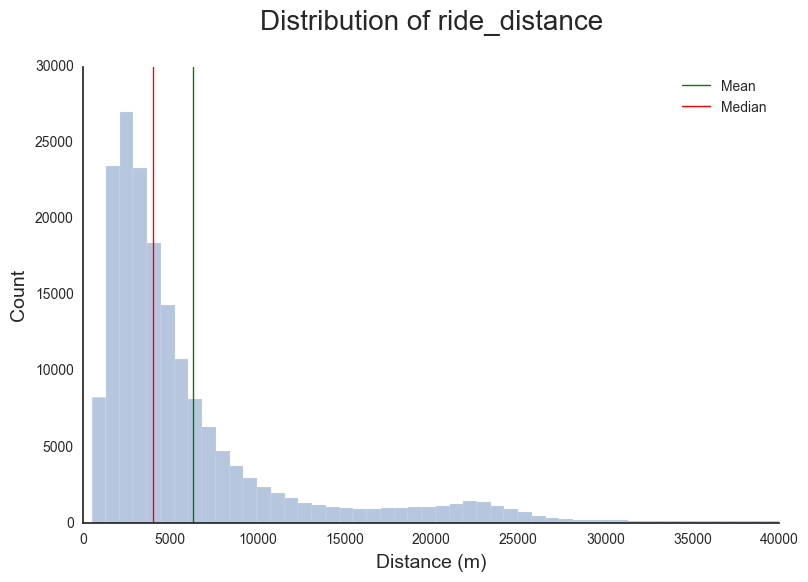

In [23]:
ax = sns.distplot(rides['ride_distance'], hist=True, kde=False)
ax.set_title('Distribution of ride_distance\n', size = 20)
sns.set_context('poster')
sns.set(style='white')
sns.despine(bottom=False)
ax.set_ylabel('Count', size = 14)
ax.set_xlabel('Distance (m)', size = 14)
ax.axvline(rides['ride_distance'].mean(), color = 'green', linewidth = 1)
ax.axvline(rides['ride_distance'].median(), color = 'red', linewidth = 1)
ax.legend(['Mean', 'Median'])
plt.show()

From the above histogram we can see that the majority of journeys are less than 10,000 meters with the average distance being ~6,300 metres.

### ride_duration

In [24]:
rides.ride_duration.describe()

count    180445.000000
mean        834.904896
std         488.761409
min          14.000000
25%         493.000000
50%         724.000000
75%        1055.000000
max       10349.000000
Name: ride_duration, dtype: float64

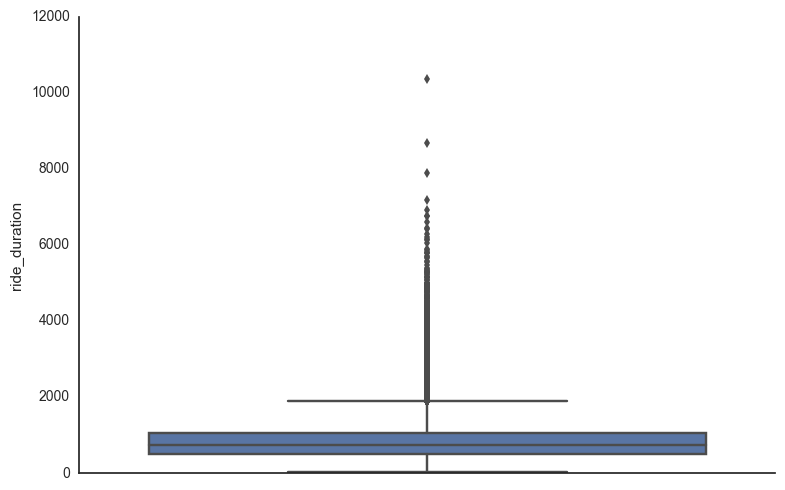

In [25]:
sns.boxplot(y=rides['ride_duration'])
sns.set_context('poster')
sns.set(style='white')
sns.despine(bottom=False)
plt.show()

From the boxplot above we can see that the majority of the journeys are less than 3,000 seconds in duration. There are a couple of outliers above this value as well as several shorter distances. I will remove rows where where ride_duration is greater than 2,000 seconds.

In [26]:
rides = rides[rides.ride_duration < 2000]

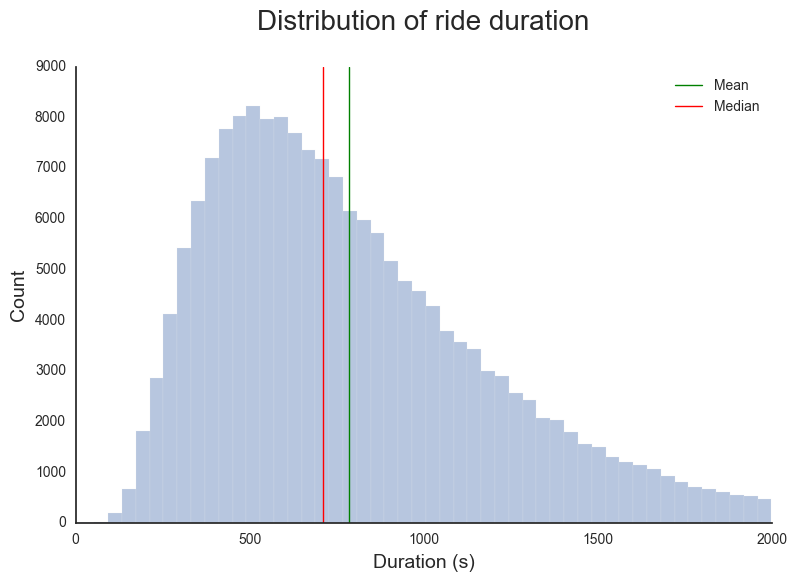

In [27]:
ax = sns.distplot(rides['ride_duration'], hist=True, kde=False)
sns.set_context('poster')
sns.set(style='white')
sns.despine(bottom=False)
ax.set_title('Distribution of ride duration\n', size = 20)
ax.set_ylabel('Count', size = 14)
ax.set_xlabel('Duration (s)', size = 14)
ax.axvline(rides['ride_duration'].mean(), color = 'green', linewidth = 1)
ax.axvline(rides['ride_duration'].median(), color = 'red', linewidth = 1)
ax.legend(['Mean', 'Median'])
plt.show()

From the above histogram we can see that the majority of journeys take less than 2,000 seconds with the average distance being ~750 seconds.

### ride_prime_time

In [28]:
rides.ride_prime_time.value_counts()

0      112914
25      30923
50      16266
75       7487
100      5727
150      1495
200       374
250        85
300        28
350        11
400         9
500         1
Name: ride_prime_time, dtype: int64

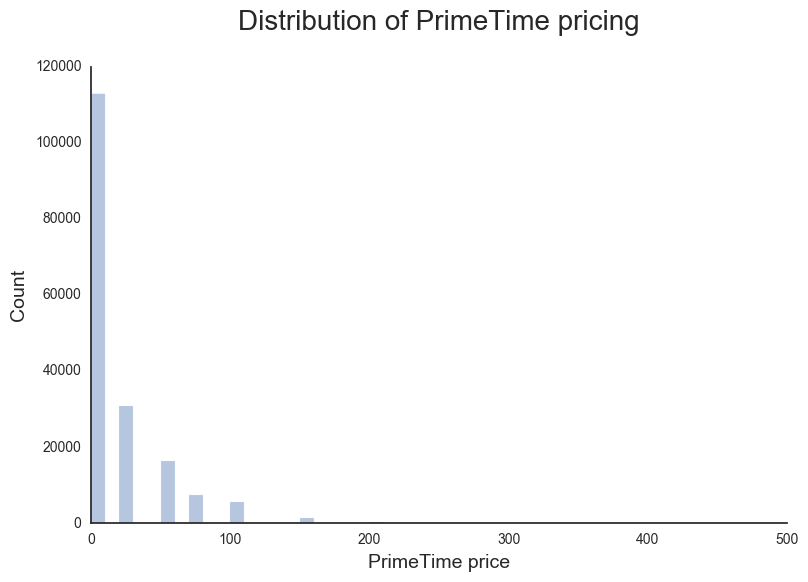

In [29]:
ax = sns.distplot(rides['ride_prime_time'], hist=True, kde=False)
sns.set_context('poster')
sns.set(style='white')
sns.despine(bottom=False)
ax.set_title('Distribution of PrimeTime pricing\n', size = 20)
ax.set_ylabel('Count', size = 14)
ax.set_xlabel('PrimeTime price', size = 14)
plt.show()

We can see that for the majority of journeys there is no PrimeTime pricing, this will be investigated in more detail further on.

### accepted_time

In [30]:
rides.accepted_time.describe()

count    175320.000000
mean         11.418977
std          32.851026
min           0.000000
25%           5.000000
50%           6.000000
75%           9.000000
max        5028.000000
Name: accepted_time, dtype: float64

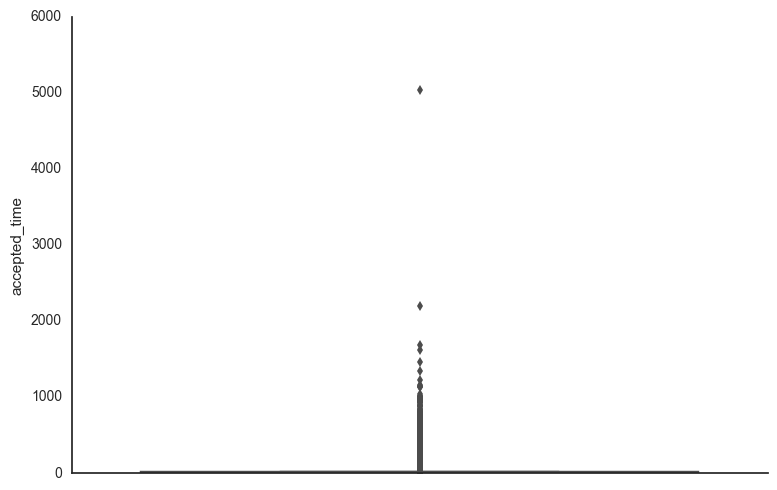

In [31]:
sns.boxplot(y=rides['accepted_time'])
sns.set_context('poster')
sns.set(style='white')
sns.despine(bottom=False)
plt.show()

From the boxplot above we can see that the majority of the journeys are are accepted in less than ten seconds. There are outliers all the way up to 5,028 seconds. I will remove rows where where acceptance time is less 60 seconds.

In [32]:
rides = rides[rides.accepted_time < 60]

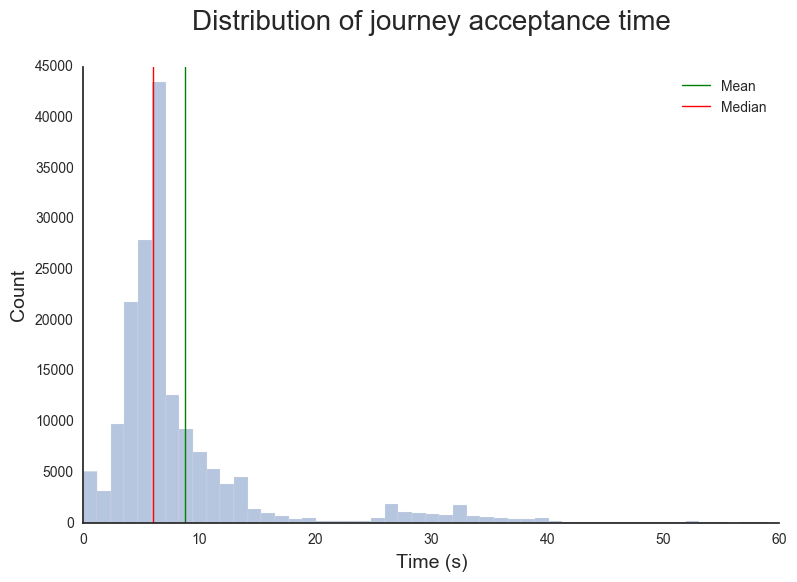

In [33]:
ax = sns.distplot(rides['accepted_time'], hist=True, kde=False)
sns.set_context('poster')
sns.set(style='white')
sns.despine(bottom=False)
ax.set_title('Distribution of journey acceptance time\n', size = 20)
ax.set_ylabel('Count', size = 14)
ax.set_xlabel('Time (s)', size = 14)
ax.axvline(rides['accepted_time'].mean(), color = 'green', linewidth = 1)
ax.axvline(rides['accepted_time'].median(), color = 'red', linewidth = 1)
ax.legend(['Mean', 'Median'])
plt.show()

The histogram showh that the majority of journeys are accepted by drivers in less than 10 seconds with a small cluster being accepted arounf the 30 second mark.

### day_of_week

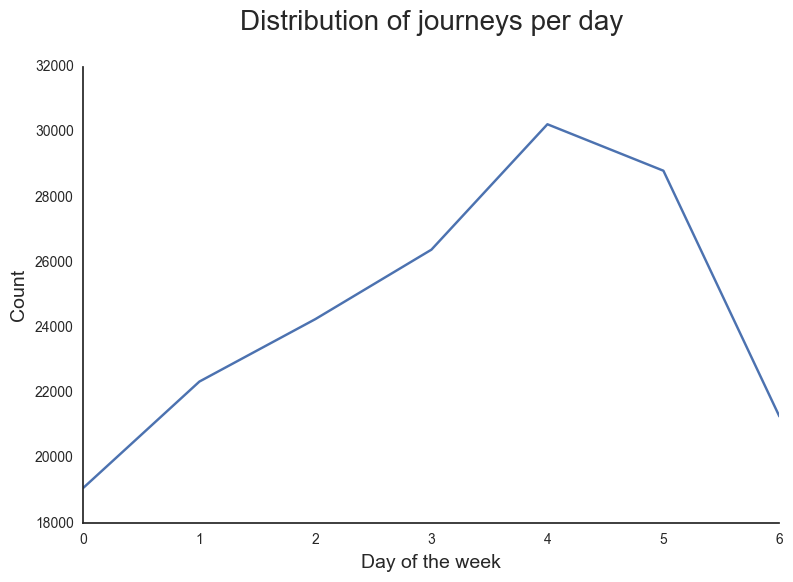

In [34]:
ax = sns.tsplot(rides.groupby('day_of_week')['day_of_week'].count())
sns.set_context('poster')
sns.set(style='white')
sns.despine(bottom=False)
ax.set_title('Distribution of journeys per day\n', size = 20)
ax.set_ylabel('Count', size = 14)
ax.set_xlabel('Day of the week', size = 14)
plt.show()

The numbers of the week refer to the days of the week with 0 = Monday and 6 = Sunday.

From the timeseries plot we can see that Monday has the least number of journeys and the number of journeys increase steadly during the week to peak on Fridays.

### month

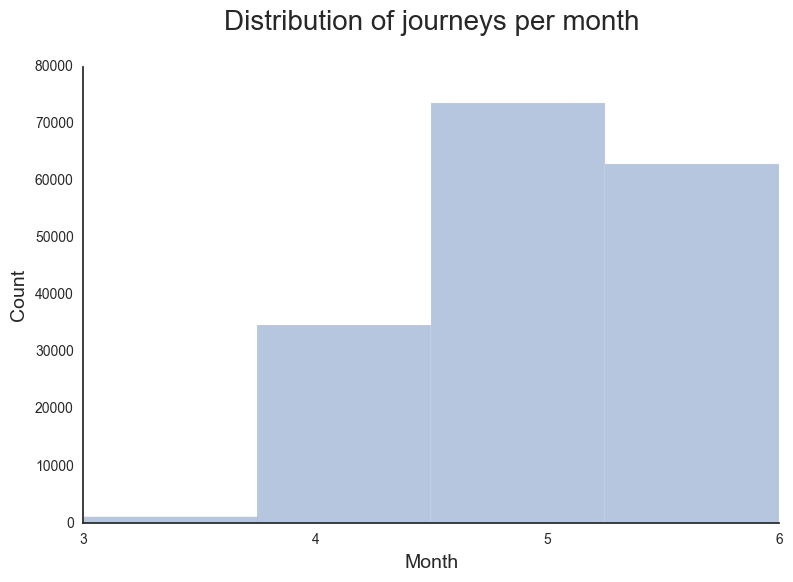

In [35]:
ax = sns.distplot(rides.month, bins=4, hist=True, kde=False)
sns.set_context('poster')
sns.set(style='white')
sns.despine(bottom=False)
ax.set_title('Distribution of journeys per month\n', size = 20)
ax.set_ylabel('Count', size = 14)
ax.set_xlabel('Month', size = 14)
ax.set_xticks(np.arange(3,7,1))
plt.show()

Like the days of the week the numbers refer to the months with 3 = March, 4 = April, etc..

From the distribution plot we can see that the majority of journey occured in May and only a few journeys happened in March. This is due to the fact that drivers were only starting to come onboard in March, as the number of drivers increases so does the number of journeys.

### hour_of_day

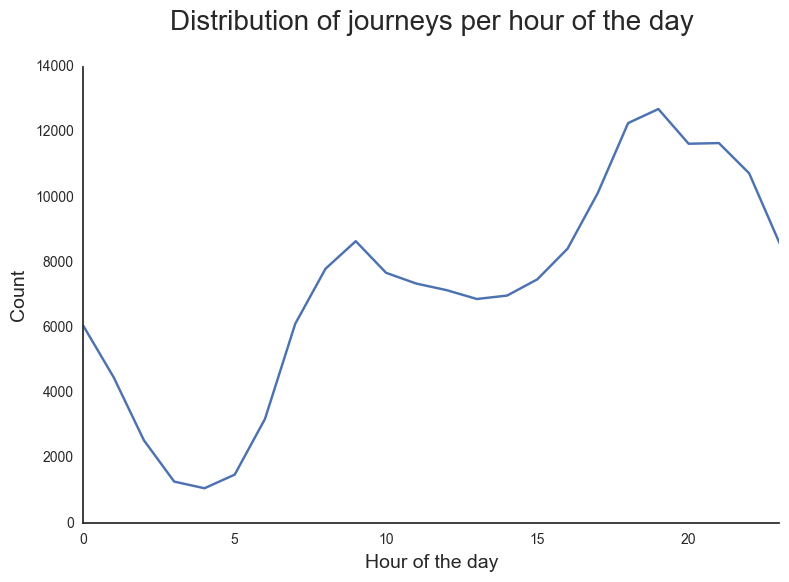

In [36]:
ax = sns.tsplot(rides.groupby('hour_of_day')['hour_of_day'].count())
sns.set_context('poster')
sns.set(style='white')
sns.despine(bottom=False)
ax.set_title('Distribution of journeys per hour of the day\n', size = 20)
ax.set_ylabel('Count', size = 14)
ax.set_xlabel('Hour of the day', size = 14)
plt.show()

We can see from the timeseries plot that the there is a peak of journeys in the morning at 08:00 and in the evening at 18:00.

### week_of_year

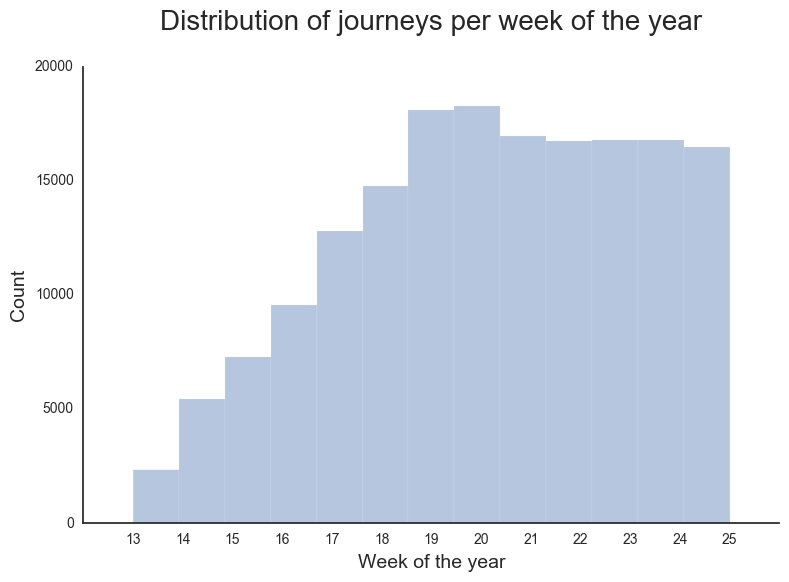

In [37]:
ax = sns.distplot(rides.week_of_year, bins=13, hist=True, kde=False)
sns.set_context('poster')
sns.set(style='white')
sns.despine(bottom=False)
ax.set_title('Distribution of journeys per week of the year\n', size = 20)
ax.set_ylabel('Count', size = 14)
ax.set_xlabel('Week of the year', size = 14)
ax.set_xticks(np.arange(13,26,1))
plt.show()

As expected we can see that that there is a gradual increase in the number journeys per week leading up to a peak in week 20, this is line with the previous distribution plot for months of the year where the peak was in May. 

### day_of_year

In [38]:
rides.day_of_year.describe()

count    172427.000000
mean        141.796830
std          22.283731
min          88.000000
25%         126.000000
50%         142.000000
75%         161.000000
max         178.000000
Name: day_of_year, dtype: float64

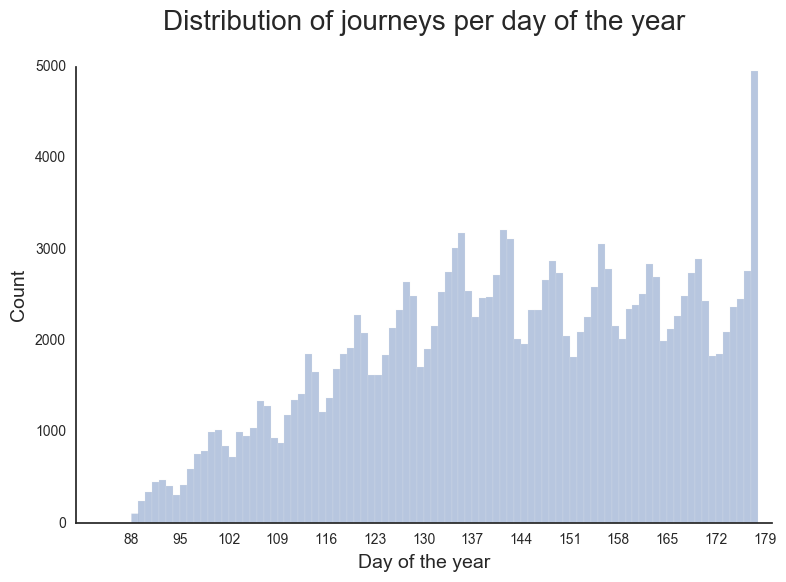

In [39]:
ax = sns.distplot(rides.day_of_year, bins=90, hist=True, kde=False)
sns.set_context('poster')
sns.set(style='white')
sns.despine(bottom=False)
ax.set_title('Distribution of journeys per day of the year\n', size = 20)
ax.set_ylabel('Count', size = 14)
ax.set_xlabel('Day of the year', size = 14)
ax.set_xticks(np.arange(88,180,7))
plt.show()

The distribution is in line with the weeks of the year with the gradual increase in the number journeys per day leading up to a peak in day 135, this is line with the previous distribution plot for months of the year where the peak was in May.

### driver_onboard_week

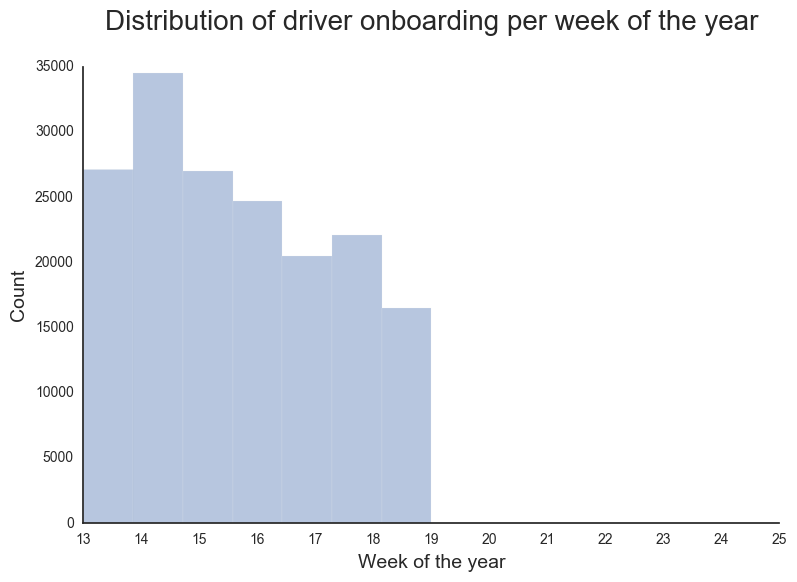

In [40]:
#sns.tsplot(rides.groupby('day_of_year')['day_of_year'].count())
ax = sns.distplot(rides.driver_onboard_week, bins=7, hist=True, kde=False)
sns.set_context('poster')
sns.set(style='white')
sns.despine(bottom=False)
ax.set_title('Distribution of driver onboarding per week of the year\n', size = 20)
ax.set_ylabel('Count', size = 14)
ax.set_xlabel('Week of the year', size = 14)
ax.set_xticks(np.arange(13,26,1))
plt.show()

From above it can be seen that a large number of drivers came onboard earlier in the four month period and then decreased over time.

### driver_onboard_day

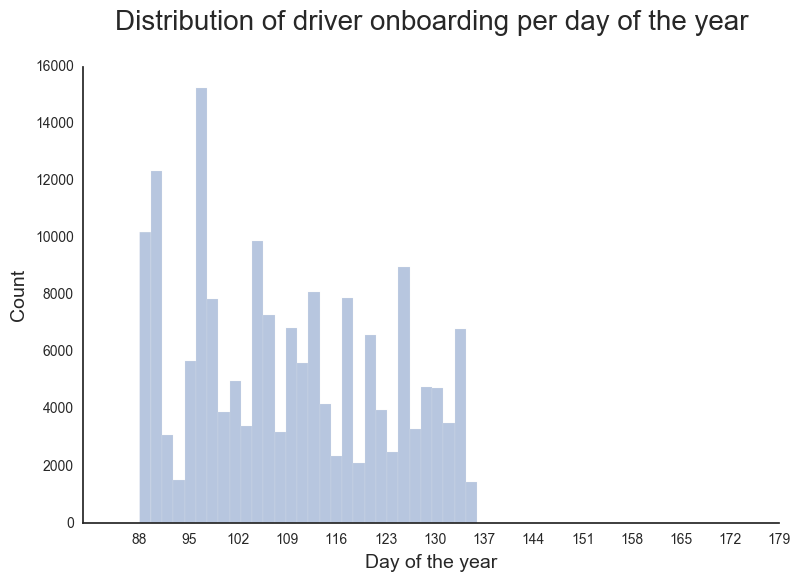

In [41]:
ax = sns.distplot(rides.driver_onboard_day, bins=30, hist=True, kde=False)
ax.set_title('Distribution of driver onboarding per day of the year\n', size = 20)
sns.set_context('poster')
sns.set(style='white')
sns.despine(bottom=False)
ax.set_ylabel('Count', size = 14)
ax.set_xlabel('Day of the year', size = 14)
ax.set_xticks(np.arange(88,180,7))
plt.show()

### driver_onboard_day

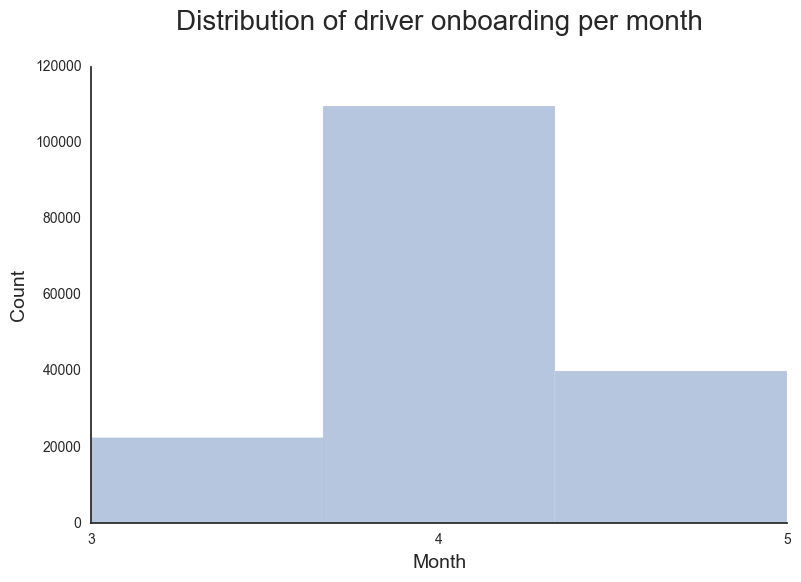

In [42]:
ax = sns.distplot(rides.driver_onboard_month, bins=3, hist=True, kde=False)
sns.set_context('poster')
sns.set(style='white')
sns.despine(bottom=False)
ax.set_title('Distribution of driver onboarding per month\n', size = 20)
ax.set_ylabel('Count', size = 14)
ax.set_xlabel('Month', size = 14)
ax.set_xticks(np.arange(3,6,1))
plt.show()

## Exploring additional features

### Average journey time taken per day of the week

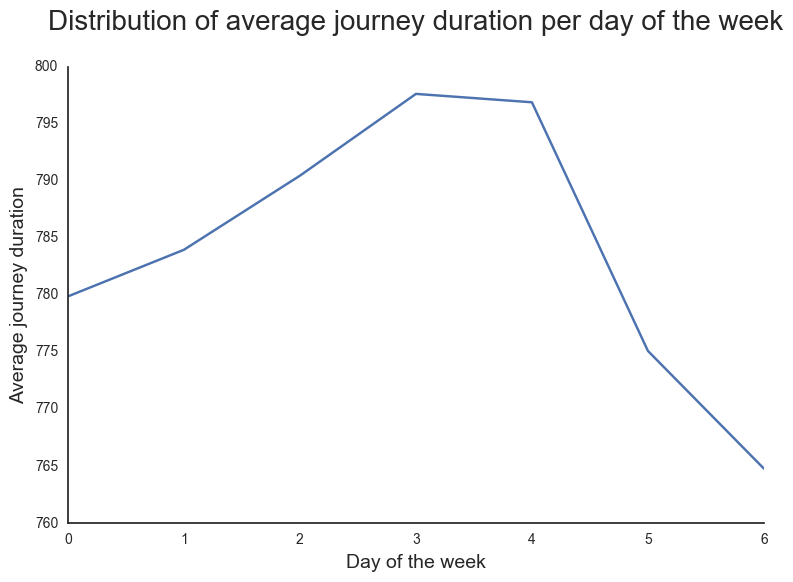

In [43]:
ax = sns.tsplot(rides.groupby('day_of_week')['ride_duration'].mean())
sns.set_context('poster')
sns.set(style='white')
sns.despine(bottom=False)
ax.set_title('Distribution of average journey duration per day of the week\n', size = 20)
ax.set_ylabel('Average journey duration', size = 14)
ax.set_xlabel('Day of the week', size = 14)
plt.show()

It is clear that the increase in the duration of the journey time correspondes to the number of journeys being undertaken on these days. More journeys causes more traffic leading to increased journey times.

### Average journey time per hour of the day

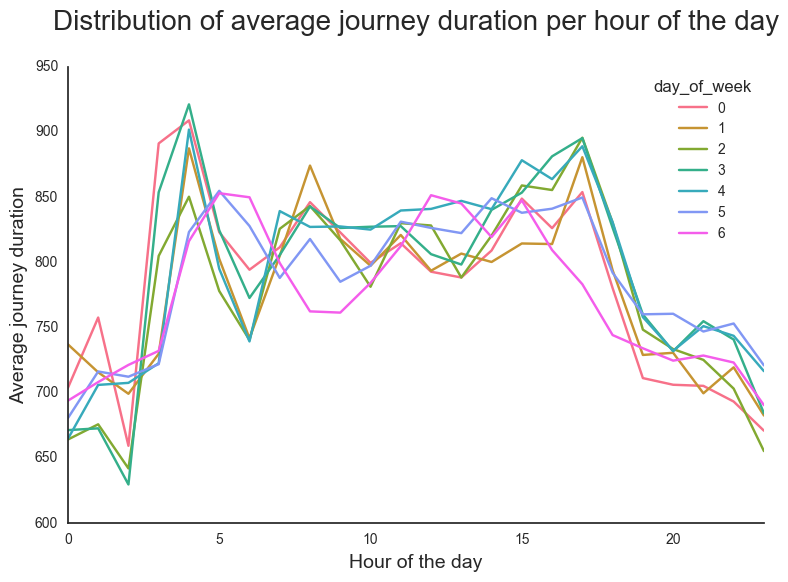

In [44]:
hours_summary = pd.DataFrame(rides.groupby(['day_of_week', 'hour_of_day'])['ride_duration'].mean())
hours_summary.reset_index(inplace=True)
hours_summary['unit'] = 1
ax = sns.tsplot(data = hours_summary, time = 'hour_of_day', unit = 'unit', 
                condition = 'day_of_week', value = 'ride_duration')
sns.set_context('poster')
sns.set(style='white')
sns.despine(bottom=False)
ax.set_title('Distribution of average journey duration per hour of the day\n', size = 20)
ax.set_ylabel('Average journey duration', size = 14)
ax.set_xlabel('Hour of the day', size = 14)
plt.show()

We can see that during the week there are longer trip durations earlier in the morning at around 5am and another peak at around 9am.

See also that on the weekend there are longer trip durations late at night and lower trip durations in the middle part of the day.

### PrimeTime rates

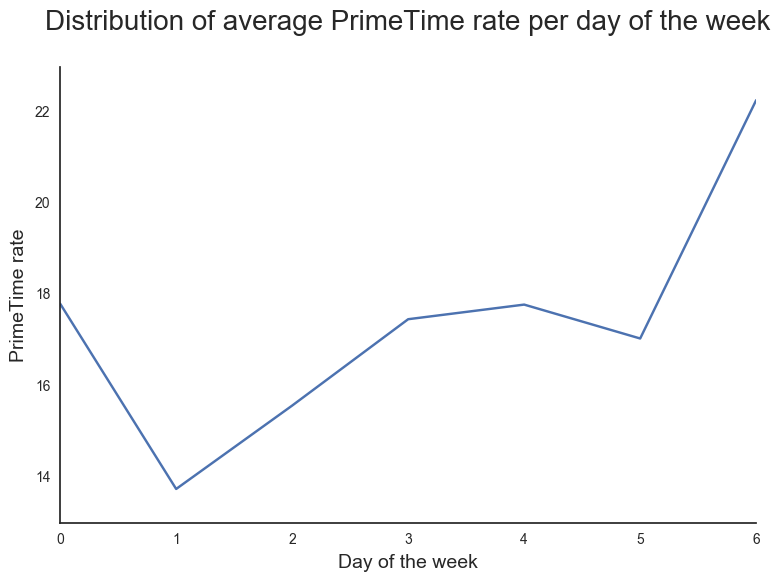

In [45]:
ax = sns.tsplot(rides.groupby('day_of_week')['ride_prime_time'].mean())
sns.set_context('poster')
sns.set(style='white')
sns.despine(bottom=False)
ax.set_title('Distribution of average PrimeTime rate per day of the week\n', size = 20)
ax.set_ylabel('PrimeTime rate', size = 14)
ax.set_xlabel('Day of the week', size = 14)
plt.show()

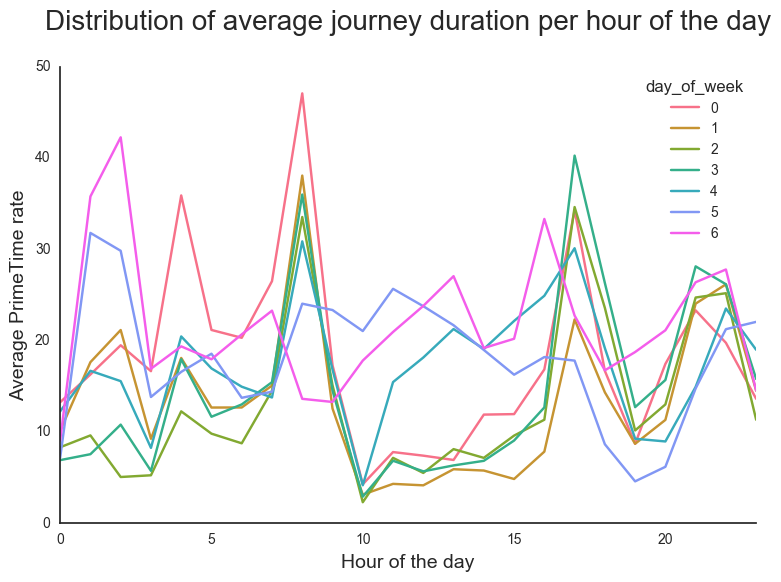

In [46]:
hours_summary = pd.DataFrame(rides.groupby(['day_of_week', 'hour_of_day'])['ride_prime_time'].mean())
hours_summary.reset_index(inplace=True)
hours_summary['unit'] = 1
ax = sns.tsplot(data = hours_summary, time = 'hour_of_day', unit = 'unit', 
                condition = 'day_of_week', value = 'ride_prime_time')
sns.set_context('poster')
sns.set(style='white')
sns.despine(bottom=False)
ax.set_title('Distribution of average journey duration per hour of the day\n', size = 20)
ax.set_ylabel('Average PrimeTime rate', size = 14)
ax.set_xlabel('Hour of the day', size = 14)
plt.show()

As expected the PrimeTime rate increases during the busy periods to encourage more drivers to deal with the demand.

- During the weekdays we can see spikes during the morning and after work peaks
- During the weekend there is there is a higher PrimeTime rate trrough out the day with spikes around 10pm asn 2am.

### Ride rates

Using the following assumption on ride costs - 

- **Base Fare** - \$2.00
- **Cost per Mile** - \$1.15
- **Cost per Minute** - \$0.22
- **Service Fee** - \$1.75
- **Minimum Fare** - \$5.00
- **Maximum Fare** - \$400.00

I will calculated the fare for each journey.

Lyft fares are calculated by -


Base fare + (Cost per minute \* time in car) + (Cost per mile \* ride distance) + service fee + PrimeTime fee

In [48]:
for row in rides.index:
    
    if rides.loc[row,('ride_prime_time')]  == 0:
    
        base = 2 + (1.15*(rides.loc[row,('ride_distance')]*
                          0.000621371)) + (0.22*(rides.loc[row,('ride_duration')]/60)) + 1.75
    else:
        
        base = 2 + (1.15*(rides.loc[row,('ride_distance')]*
                          0.000621371)) + (0.22*(rides.loc[row,('ride_duration')]/60)) + 1.75
        base = base +(base*(rides.loc[row,('ride_prime_time')]/100))
    
    if base  < 5:
        fare = 5
    elif base < 400:
        fare = base
    else:
        fare = 400
    
    
    rides.loc[row,('fare')] = fare

In [49]:
rides['fare'].describe()

count    172427.000000
mean         11.168663
std           5.974943
min           5.000000
25%           7.341281
50%           9.322981
75%          12.690645
max         152.822858
Name: fare, dtype: float64

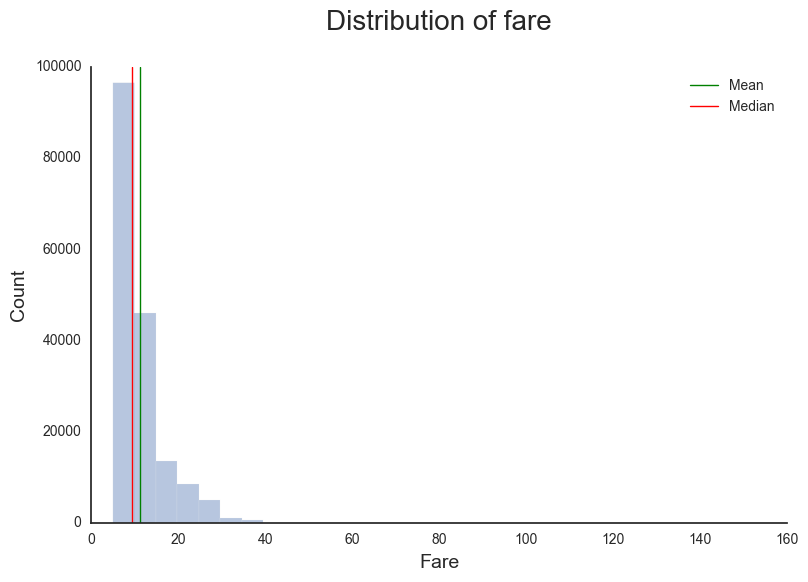

In [50]:
ax = sns.distplot(rides['fare'], hist=True, kde=False, bins=30)
sns.set_context('poster')
sns.set(style='white')
sns.despine(bottom=False)
ax.set_title('Distribution of fare\n', size = 20)
ax.set_ylabel('Count', size = 14)
ax.set_xlabel('Fare', size = 14)
ax.axvline(rides['fare'].mean(), color = 'green', linewidth = 1)
ax.axvline(rides['fare'].median(), color = 'red', linewidth = 1)
ax.legend(['Mean', 'Median'])
plt.show()

The majority of fares are below \$20 with the average fare coming in at ~\$10.

## Measuring Lifetime Value

### Main factors

Some of the main metrics for determining a driver's Lifetime Value from the data provided are:

- driver response time
- hours worked per week
- fare generated
- no. of completed trips

We are looking for drivers that work that have consistant working hours that can meet demand at peak times.

### Average lifetime of a driver

In [51]:
# Take the start day and week that a driver starts and the last day they worked 
lifetime = rides.pivot_table(index='driver_id', values=('day_of_year', 'week_of_year', 
                                                        'driver_onboard_day', 'driver_onboard_week'), aggfunc=np.max)

In [52]:
# Determine the amount of time a driver has worked
lifetime['no_weeks'] = lifetime['week_of_year'] - lifetime['driver_onboard_week']
lifetime['no_days'] = lifetime['day_of_year'] - lifetime['driver_onboard_day']

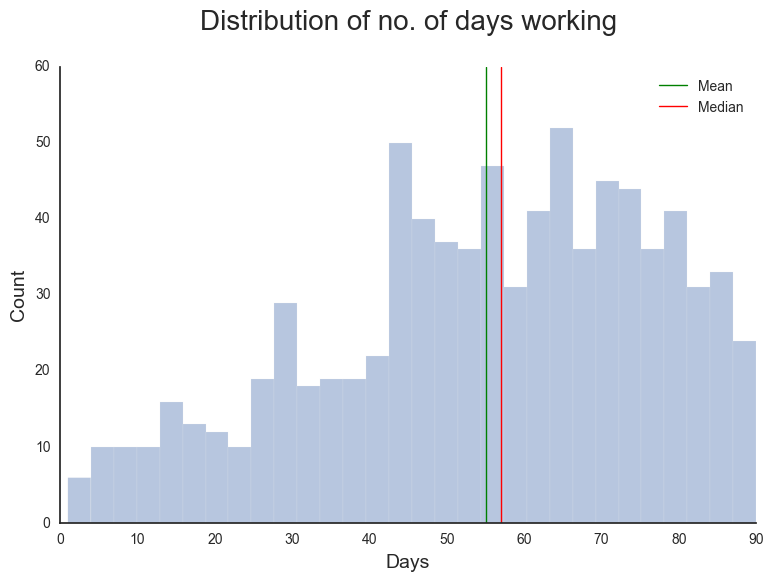

In [53]:
ax = sns.distplot(lifetime['no_days'], hist=True, kde=False, bins=30)
sns.set_context('poster')
sns.set(style='white')
sns.despine(bottom=False)
ax.set_title('Distribution of no. of days working\n', size = 20)
ax.set_ylabel('Count', size = 14)
ax.set_xlabel('Days', size = 14)
ax.axvline(lifetime['no_days'].mean(), color = 'green', linewidth = 1)
ax.axvline(lifetime['no_days'].median(), color = 'red', linewidth = 1)
ax.legend(['Mean', 'Median'])
plt.show()

In the four months that the data was collected we can see that an average driver has worked for a period of 55 days.

It is important to note that onboarding started earnestly in the first month and gradually increased as time progressed.

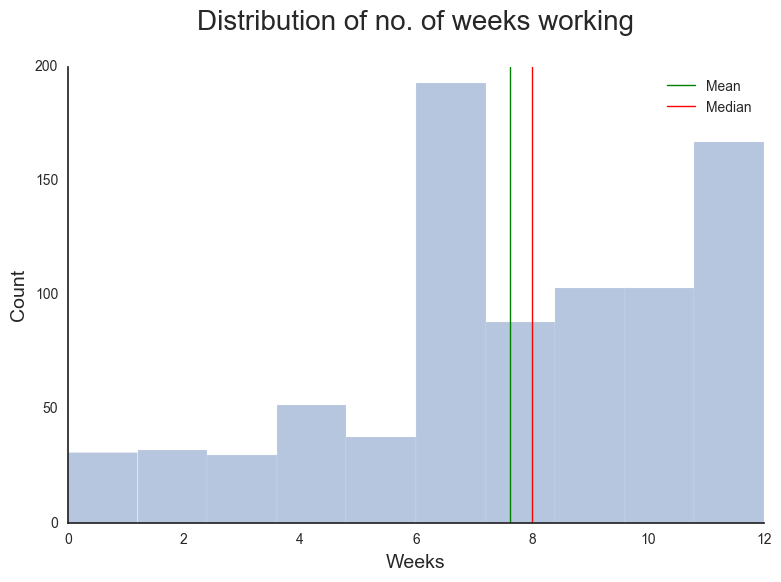

In [54]:
ax = sns.distplot(lifetime['no_weeks'], hist=True, kde=False, bins=10)
sns.set_context('poster')
sns.set(style='white')
sns.despine(bottom=False)
ax.set_title('Distribution of no. of weeks working\n', size = 20)
ax.set_ylabel('Count', size = 14)
ax.set_xlabel('Weeks', size = 14)
ax.axvline(lifetime['no_weeks'].mean(), color = 'green', linewidth = 1)
ax.axvline(lifetime['no_weeks'].median(), color = 'red', linewidth = 1)
ax.legend(['Mean', 'Median'])
plt.show()

Echoing the above we can see that an average driver has worked for a period of ~7.5 weeks.

### Driver Churn

For the purpose of this assignment I will assume that once a drivers doesn't drive for a week they have churned, so any driver that has not driven in the last week will be treated as churned.

In [55]:
churned = lifetime[lifetime['week_of_year'] < 25]
print 'There are', churned.shape[0], 'churned drivers.'

There are 323 churned drivers.


This accounts for ~39% of the total drivers.

In [56]:
# Create a new column and add a binary indication of churn, 1 for churn and 0 otherwise

lifetime['churn'] = 0

for row in lifetime.index:
    
    if lifetime.loc[row,('week_of_year')]  < 25:
    
        lifetime.loc[row,('churn')] = 1

### Average hours worked per week

In [57]:
# Take the start day and week that a driver starts and the last day they worked 
time_worked = rides.pivot_table(index='driver_id', values=('ride_duration'), aggfunc=np.sum)
lifetime['time_worked'] = time_worked

# Convert from seconds to hours
lifetime['time_worked'] = lifetime['time_worked'] / 3600

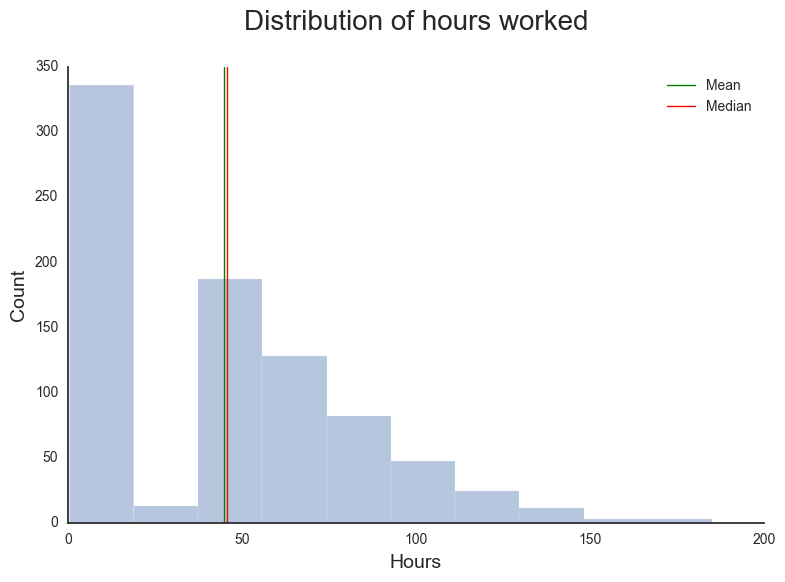

In [58]:
ax = sns.distplot(lifetime['time_worked'], hist=True, kde=False, bins=10)
sns.set_context('poster')
sns.set(style='white')
sns.despine(bottom=False)
ax.set_title('Distribution of hours worked\n', size = 20)
ax.set_ylabel('Count', size = 14)
ax.set_xlabel('Hours', size = 14)
ax.axvline(lifetime['time_worked'].mean(), color = 'green', linewidth = 1)
ax.axvline(lifetime['time_worked'].median(), color = 'red', linewidth = 1)
ax.legend(['Mean', 'Median'])
plt.show()

This information only takes into account the amount of time a drives spends on paid journeys. The actual time the driver spends working is not represented.

We can see a good portion of the drivers spent 10 hours or less driving passengers. The average number of hours spent driving was ~50 hours.

### Average fares generated per hour

In [59]:
# Take the sum of a drivers over their lifetime
fares = rides.pivot_table(index='driver_id', values=('fare'), aggfunc=np.sum)
lifetime['fare'] = fares

# Convert to fare per hour
lifetime['fare'] = lifetime['fare'] / lifetime['time_worked']

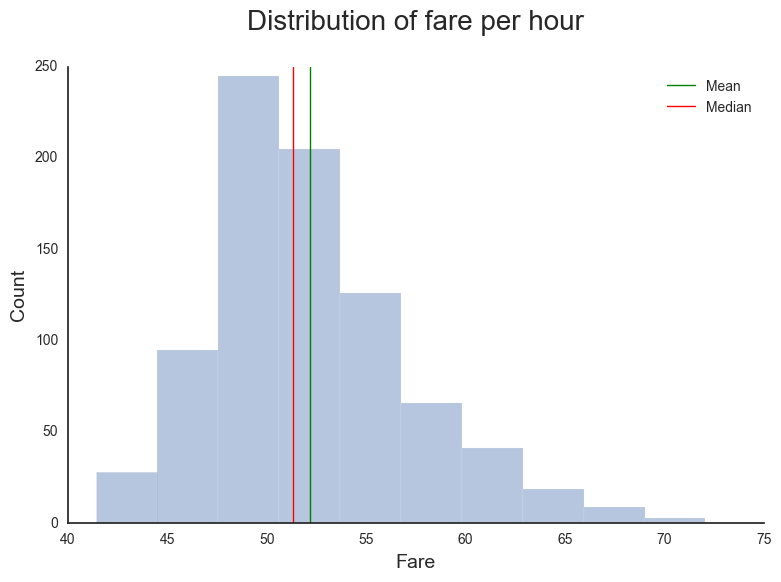

In [60]:
ax = sns.distplot(lifetime['fare'], hist=True, kde=False, bins=10)
sns.set_context('poster')
sns.set(style='white')
sns.despine(bottom=False)
ax.set_title('Distribution of fare per hour\n', size = 20)
ax.set_ylabel('Count', size = 14)
ax.set_xlabel('Fare', size = 14)
ax.axvline(lifetime['fare'].mean(), color = 'green', linewidth = 1)
ax.axvline(lifetime['fare'].median(), color = 'red', linewidth = 1)
ax.legend(['Mean', 'Median'])
plt.show()

As above, this only takes into account the time that a driver was driving passengers and is an average over all the PrimeTime prices.

We can see from the distribution plot that the average hourly rate is ~\$52.

### Number of completed journeys

In [61]:
# Take the count of a drivers journeys over their lifetime
no_rides = rides.pivot_table(index='driver_id', values=('fare'), aggfunc='count')
lifetime['no_rides'] = no_rides

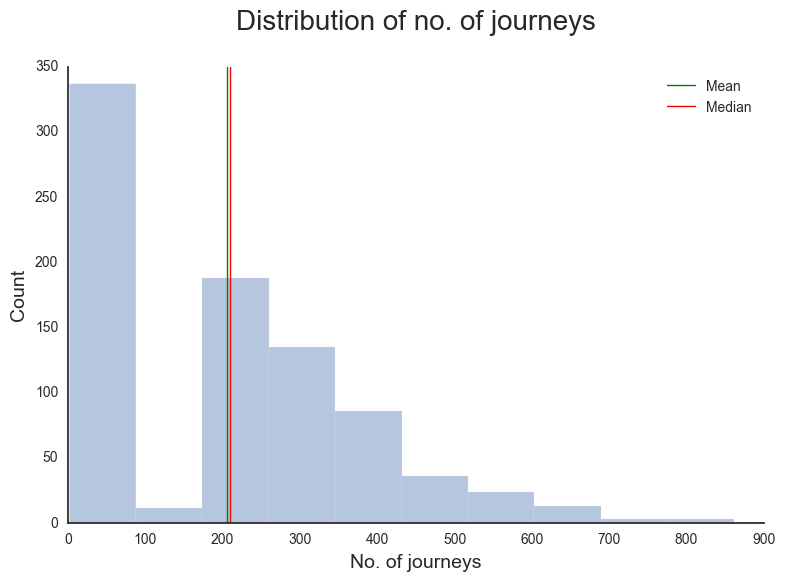

In [62]:
ax = sns.distplot(lifetime['no_rides'], hist=True, kde=False, bins=10)
sns.set_context('poster')
sns.set(style='white')
sns.despine(bottom=False)
ax.set_title('Distribution of no. of journeys\n', size = 20)
ax.set_ylabel('Count', size = 14)
ax.set_xlabel('No. of journeys', size = 14)
ax.axvline(lifetime['no_rides'].mean(), color = 'green', linewidth = 1)
ax.axvline(lifetime['no_rides'].median(), color = 'red', linewidth = 1)
ax.legend(['Mean', 'Median'])
plt.show()

The average number of journeys made by a driver in their lifetime is 206.

### Driver response time

In [63]:
# Take the sum of a drivers responsetimes over their lifetime
response_time = rides.pivot_table(index='driver_id', values=('accepted_time'), aggfunc=np.sum)
lifetime['response_time'] = response_time

# Convert to averance response time per journey
lifetime['response_time'] = lifetime['response_time'] / lifetime['no_rides']

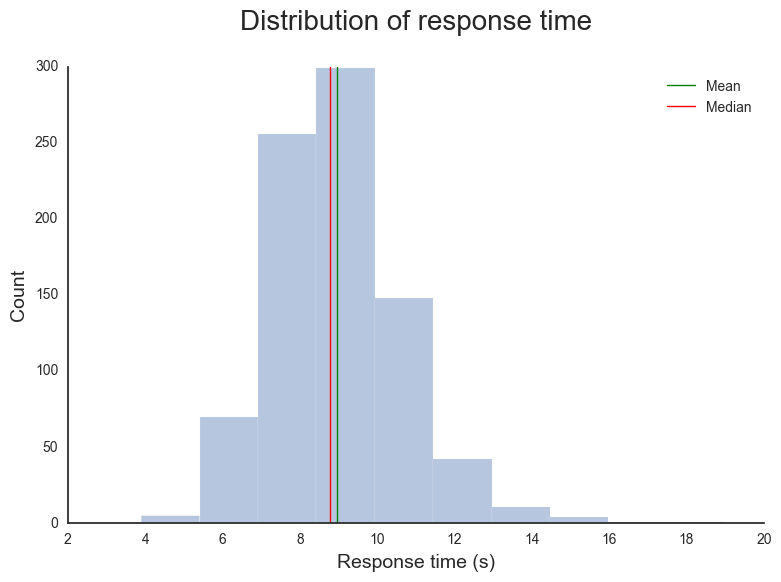

In [64]:
ax = sns.distplot(lifetime['response_time'], hist=True, kde=False, bins=10)
sns.set_context('poster')
sns.set(style='white')
sns.despine(bottom=False)
ax.set_title('Distribution of response time\n', size = 20)
ax.set_ylabel('Count', size = 14)
ax.set_xlabel('Response time (s)', size = 14)
ax.axvline(lifetime['response_time'].mean(), color = 'green', linewidth = 1)
ax.axvline(lifetime['response_time'].median(), color = 'red', linewidth = 1)
ax.legend(['Mean', 'Median'])
plt.show()

This looks like a fairly normal distribution for the response time with drivers accepting requests for journeys in an average of 9s.

## Modelling

In [65]:
# Libraries for modelling
from sklearn import datasets, metrics, linear_model, feature_selection, preprocessing
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, confusion_matrix
from sklearn.model_selection import cross_val_predict, cross_val_score, train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
import itertools

I will use Logistic Regression to try and predict churn determine.

The target will be the churn variable I created previously.

The feature set will include - 

- no_days
- time_worked
- fare
- no_rides
- response_time

In [66]:
# Define target and feature set for modelling
X = lifetime[['no_days', 'time_worked', 'fare', 'no_rides', 'response_time']]
y = lifetime.churn

In [67]:
# Define the scaler
ss = StandardScaler()

# Scaling the feature set
Xs = ss.fit_transform(X)

Accuracy: 0.845878136201


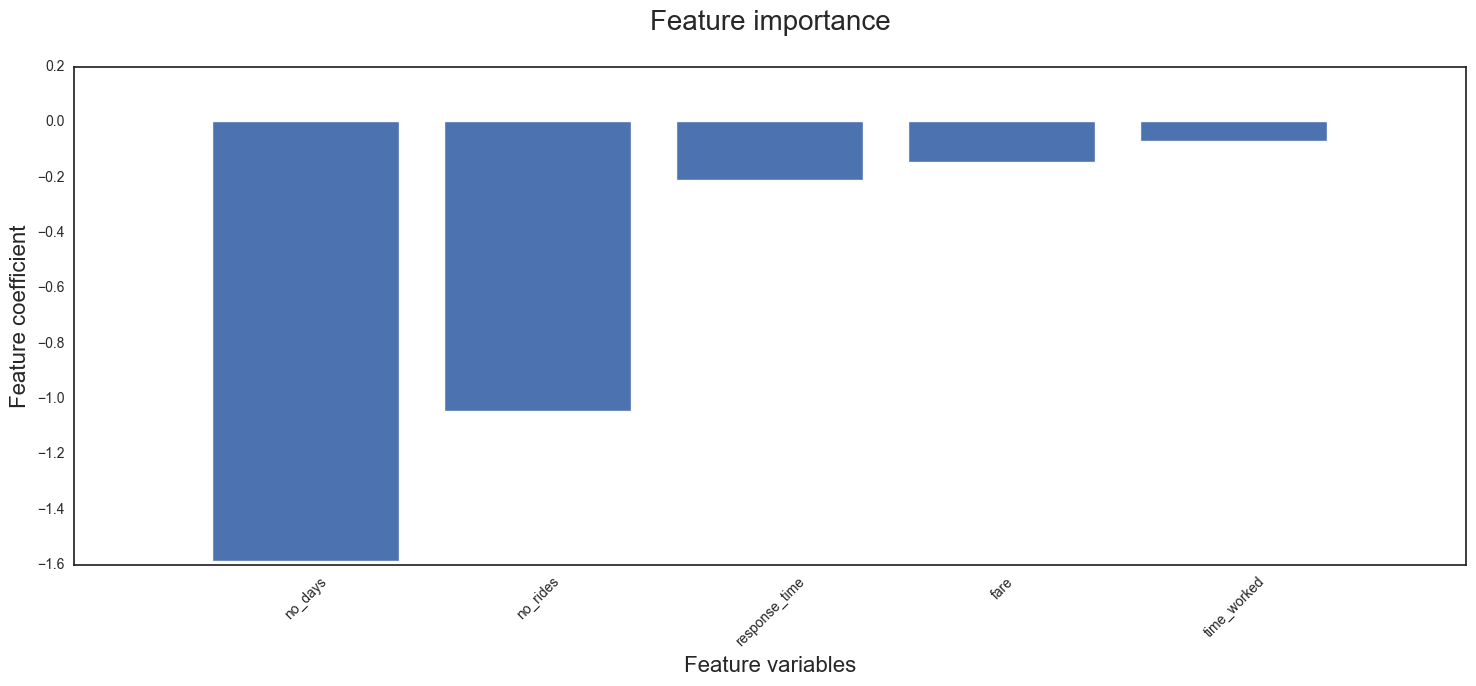

In [68]:
# Defining our model
# Using the standard paramaeters of the model
lr = LogisticRegression()

# Fitting the model with our target and features
model = lr.fit(Xs, y)
# Determins preditions from the model and print the accuracy of the model
predictions = model.predict(Xs)
print 'Accuracy:', accuracy_score(y, predictions)

# Setting the feature importance to a variable
feat_importance = model.coef_
# Sorting the feature importance
indices = np.argsort(np.absolute(feat_importance))

# Plotting the feature importance
plt.figure(figsize = (16, 6))
plt.title("Feature importance\n", fontsize = 20)
plt.bar(range(Xs.shape[1]), feat_importance[0][indices][0][::-1], align="center")
plt.ylabel('Feature coefficient', size = 16)
plt.xlabel('Feature variables', size = 16)
plt.xticks(range(X.shape[1]), X.columns[indices][0][::-1], rotation=45)
plt.xlim([-1, X.shape[1]])
plt.show()

In [69]:
# Create a dataframe to display the odds ratio
odds_ratio = pd.DataFrame(np.transpose(model.coef_), index = X.columns, columns = ["Coeffecient value"])
# Create the odds colums by calculating the exponential of the coefficients
odds_ratio["Odds"] = odds_ratio["Coeffecient value"].apply(np.exp)
# Display the odds ratio
odds_ratio.sort_values(by = 'Odds', ascending = False)

,Coeffecient value,Odds
time_worked,-0.068011,0.934251
fare,-0.144500,0.865455
response_time,-0.206385,0.813519
no_rides,-1.044191,0.351976
no_days,-1.584099,0.205132


From the above chart and table we can see **time_worked**, **fare** and **response_time** come out on top for predicting churn with an accuracy of 0.845.

### Cross-validation

Using cross-validation I will evaluate different metrics -
- Accuracy = (TP+TN)/total
- Precision = TP/(TP+FP)
- Recall = TP/(TP+FN)

I will also plot a confusion matrix to understand these metrics better as well as a receiver operating characteristic (ROC) curve to look at the area under the curve (AUC)

In [70]:
# List the metrics for evaluation
metrics = ['accuracy', 'precision', 'recall']

# Define the model 
# Using L2 regularisation and 5-fold cross-validation
lg = LogisticRegressionCV(penalty = 'l2', cv = 5, solver = 'liblinear') 

# Loop through the different metrics and print the mean of the metric after the 5-fold cross-validation
for metric in metrics:
    
    scores = cross_val_score(lg, Xs, y, scoring = metric, cv = 5)
    
    print metric, ':' , scores.mean()

accuracy : 0.832839828089
precision : 0.80477213133
recall : 0.746298076923


#### Confucion Matrix

In [71]:
# Define a function for plotting confusion matrix
def plot_confusion_matrix(cm, classes, title='Confusion matrix for high/low salaries\n', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True salary')
    plt.xlabel('Predicted salary')
    plt.show()
    return

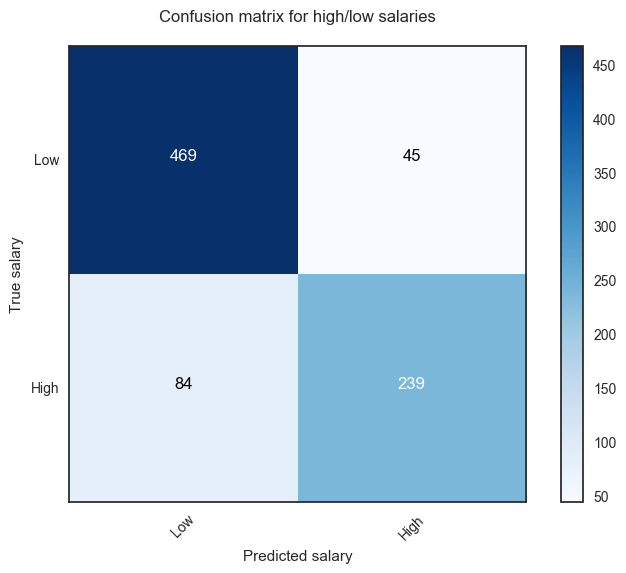

In [72]:
# Plot confusion matrix
cnf_matrix = confusion_matrix(y, model.predict(Xs))
plot_confusion_matrix(cnf_matrix, classes= ['Low', 'High'])

#### ROC curve

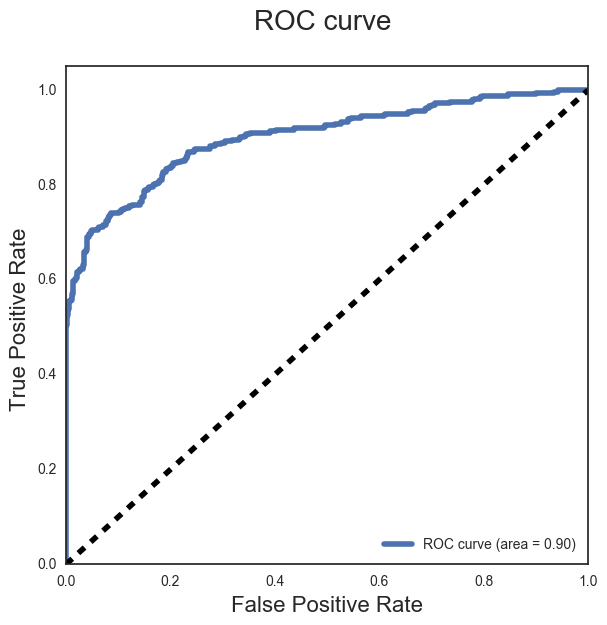

In [73]:
# Plot ROC curve
FPR, TPR, THR = roc_curve(y, model.predict_proba(Xs)[:,1])
ROC_AUC = auc(FPR, TPR)

plt.figure(figsize=[6,6])
plt.plot(FPR, TPR, label='ROC curve (area = %0.2f)' % ROC_AUC, linewidth = 4)
plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate ', fontsize=16)
plt.title('ROC curve \n', fontsize=20)
plt.legend(loc="lower right")
plt.show()

The accuracy answers the question - _Overall, how often is the classifier correct?_
    - For this model the accuracy score was 0.83 which is a good accuracy for the model and above the baseline. This means that model is good at predicting churn over random choice 


The precision answers the question -  _When it predicts yes, how often is it correct?_
    - The score for the precision on this model was ~0.8


The recall answers the question - _When it's actually yes, how often does it predict yes?_
    - The score for the precision on this model was 0.74

#### Gridsearch

To try and improve the model I will perform a GridSearch using different parameters to try and report the best model.

In [74]:
# Define the GridSearch parameters
params = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
          'penalty': ['l1','l2']
         }

# Define the model
grid = GridSearchCV(LogisticRegression(), params, cv=5)
# fit the model
grid.fit(Xs, y)
# Print the beat parameters to use
print grid.best_params_

{'penalty': 'l2', 'C': 1}


The best parameters identified by the GridSearch were - 

- penalty of l2 (Ridge)
- C value of 1

I will run another regression with these parameters.

In [75]:
# Define the model 
# Using L2 regularisation, C = 1 and solver = liblinear as this is better for smaller datasets
lggs = LogisticRegression(penalty = 'l2', C = 1, solver = 'liblinear')

# Fit the model with our target and features
lggs.fit(Xs, y)

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [76]:
# List the metrics for evaluation again
metrics = ['accuracy', 'precision', 'recall']

# Loop through the different metrics and print the mean of the metric after the 5-fold cross-validation
for metric in metrics:
    
    scores = cross_val_score(lggs, Xs, y, scoring = metric, cv = 5)
    
    print metric, ':' , scores.mean()

accuracy : 0.840054400665
precision : 0.829522312069
recall : 0.736971153846


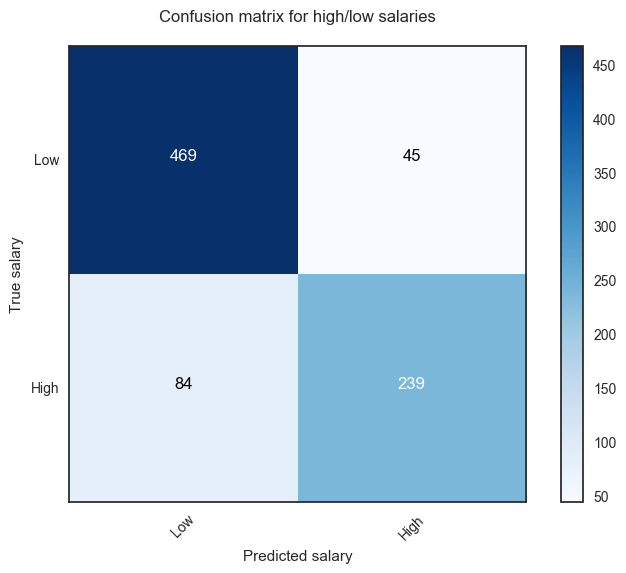

In [77]:
# Plot confusion matrix
cnf_matrix = confusion_matrix(y, lggs.predict(Xs))
plot_confusion_matrix(cnf_matrix, classes= ['Low', 'High'])

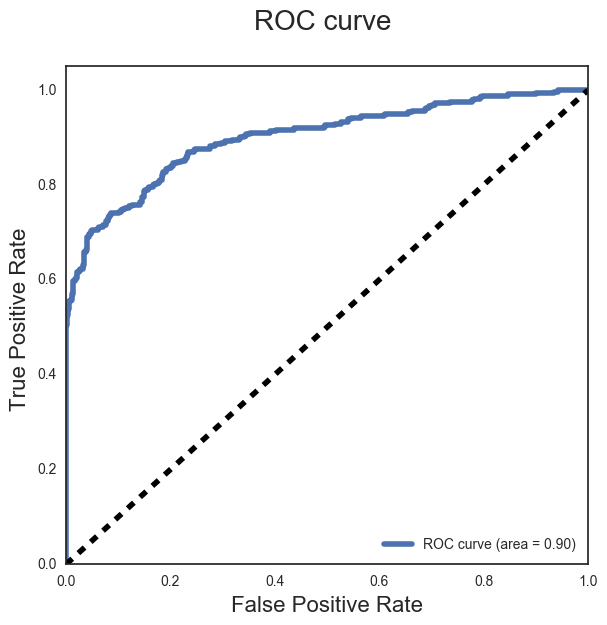

In [78]:
# Plot ROC curve
FPR, TPR, THR = roc_curve(y, lggs.predict_proba(Xs)[:,1])
ROC_AUC = auc(FPR, TPR)

plt.figure(figsize=[6,6])
plt.plot(FPR, TPR, label='ROC curve (area = %0.2f)' % ROC_AUC, linewidth = 4)
plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate ', fontsize=16)
plt.title('ROC curve \n', fontsize=20)
plt.legend(loc="lower right")
plt.show()

There wasn't a noticable increase in the metric scores after using the optimised parameters identified from the GridSearch. This means that the original model was optimised to begin with.

## Summary

By analysing the datasets we were able to derive a lot of useful information about driver behaviour.

Additional insights were obtained by performing some feature engineering on the datasets and these were used to identify factors that contribute to a driver's Lifetime Value.

An optimised Logistic Regression model was used on the following features:
- **no_days**
- **time_worked**
- **fare**
- **no_rides**
- **response_time**

With an accuracy score od 0.84 the following deatures - 

- **time_worked** 
- **fare** 
- **response_time** 

Emmerged as being the best predisctors for identifying churn.

This is in keeping with what one would expect from a successful driver, a promt service providing a supply when there is most need for it.


### Further work

Moving forward with the analysis it would be interesting to - 

- look deeper into the timeseries data to gain a better understanding of driver and customer behaviours (driver/customer wait times, more accurate driver working houre, etc.)
- undertake a more indept cohort analysis of the drivers to gain a better insight of the churn
- try different features in the churn modelling modelling to try and optimise the model and identify additional factors for prediction driver Lifetime Value
- use dirrent machine learning models on the data, Regression, Random Forests, to see if the can improve on the prediction of churn on new users
